In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

import matplotlib.gridspec as gridspec

import numpy as np
import gzip
import json
import re
import copy
from ineqpy import gini

from shapely.geometry import Point
import geopandas as gpd

In [2]:
# simulation results created by the paring results notebook
df = pd.read_csv('results_05_19.csv.gz')

# reading in aggregated taxi data
taxis = pd.concat([pd.read_csv('../nyc_data/trip_data_'+str(i)+'_taxis_per_hour.csv.gz',compression='gzip') for i in range(1,13)])
trips = pd.concat([pd.read_csv('../nyc_data/trip_data_'+str(i)+'_trips_per_hour.csv.gz',compression='gzip') for i in range(1,13)])
avg_vl = pd.concat([pd.read_csv('../nyc_data/trip_data_'+str(i)+'_avg_v_l.csv.gz',compression='gzip') for i in range(1,13)])

# joining data
taxis.set_index(['dayofyear','hour'],inplace=True)
trips.set_index(['dayofyear','hour'],inplace=True)
avg_vl.set_index(['dayofyear','hour'],inplace=True)
final_agg = taxis.join(trips).join(avg_vl)

# calculating parameters
final_agg['R'] = final_agg.apply(lambda row: row['trip_cnt']*row['l_avg']/(row['v_avg']*3600*row['taxi_cnt']),axis=1)
final_agg['d'] = np.sqrt(783.8e6/final_agg['taxi_cnt'])
final_agg.reset_index(inplace=True)

# sample days for checking
avg_day_jan = final_agg[final_agg['dayofyear']==15].groupby('hour').mean()[['R','d','taxi_cnt']]

In [3]:
# if this is the result of multiple runs, calculate mean and std per parent run_id
temp = df.groupby('parent_run_id').agg([np.mean, np.std])[['avg_request_lengths', '20/20_ratio', 'atkinson', 'gini', 'avg_time_cruising','avg_time_serving', 'avg_time_to_request', 'avg_time_waiting',
       'avg_trip_income', 'std_time_cruising', 'std_time_serving',
       'std_time_to_request', 'std_time_waiting', 'std_trip_income']]
temp.columns = ['_'.join(col).strip() for col in temp.columns.values]

# append calculated values to other conf columns
df = pd.concat([df.groupby('parent_run_id').first(),temp],axis=1)

df['rho'] = round(1/df['d']**2*1e6,0)

cond_waiting = (df['behaviour']=='stay') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond_cruising = (df['behaviour']=='go_back') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond_simple_geom  = (df["geom"]==0)

colors = ["#44af69", "#c5283d", "#2E86AB", "#182825", "#efcb00","#FFC0CB","#FF8C00"]
markers = ['o','v','s','']
markers_all = ['o','v','s','X','p']
linestyles=['-','--','-.','']
st = dict(color=colors[0:3],linewidth=2,markersize=7,legend=False,style='.-',alpha=0.7)
# global fontsize
fs = 15

# Figure 1

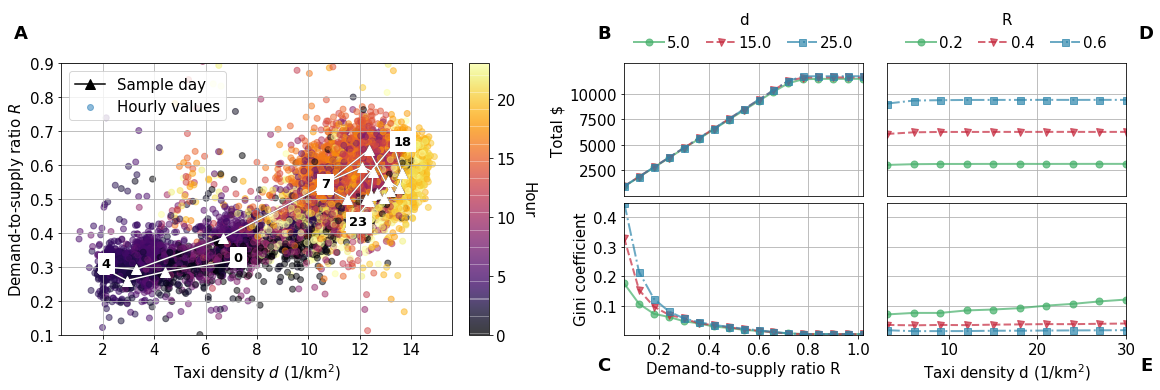

In [45]:
# defining layout and axis labels and ticks

plt.rcParams['font.size'] = fs
plt.rcParams['figure.figsize'] = 17,5

gs1 = gridspec.GridSpec(1,2,width_ratios=(0.95,0.05))
gs1.update(left=0.05,right=0.4,wspace=0.08)
ax1 = plt.subplot(gs1[0,0])
ax_cbar = plt.subplot(gs1[0,1])

gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=0.51, right=0.92, hspace=0.05,wspace=0.1)
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs2[1,0])
ax4 = plt.subplot(gs2[0,1])
ax5 = plt.subplot(gs2[1,1])

# plotting the data

cax = ax1.scatter(final_agg['taxi_cnt']/783,final_agg['R'],c=final_agg['hour'],cmap='inferno',alpha=0.5,label='Hourly values')
ax1.plot(avg_day_jan['taxi_cnt']/783,avg_day_jan['R'],'^k-',markersize=10,label="Sample day")
ax1.plot(avg_day_jan['taxi_cnt']/783,avg_day_jan['R'],'^w-',markersize=10,label="_nolegend_")
for e in [0,4,7,18,23]:
    ax1.annotate(
        str(e),
        (avg_day_jan['taxi_cnt'][e]/783,avg_day_jan['R'][e]),
        backgroundcolor="white",
        color="black",
        fontweight='extra bold',fontsize=13)
ax1.legend()
#ax1.set_colorbar(label='hour')
#plt.xlim(200,850)
ax1.set_ylim(0.1,0.9)
#plt.gca().invert_xaxis()
ax1.set_xlabel(r'Taxi density $d$ (1/km$^2$)')
ax1.set_ylabel(r'Demand-to-supply ratio $R$')
cb = plt.colorbar(cax,cax=ax_cbar)
cb.set_label('Hour',rotation=-90,labelpad=20)

# plotting fix d income and Gini plots (ax2,ax3)

cond_d_slice = (df['rho'].map(lambda i: int(round(i,0)) in [5,15,25]))
cond_R_slice = (df['R'].map(lambda r: int(round(r*100,0))%6==0))
cond_alg = (df['matching']=='nearest')
cond = cond_simple_geom&cond_d_slice&cond_waiting&cond_R_slice      
      
df[cond]\
.pivot_table(values='avg_trip_income_mean',index='R',columns='rho',aggfunc=lambda x: x)\
.plot(ax=ax2,**st)

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_xaxis().get_label(),visible=False)
ax2.tick_params(axis="x",length=0.0)
sticks=[2500,5000,7500,10000]
ax2.set_yticks(sticks)
ax2.set_ylim(0,13000)
ax2.set_ylabel("Total $", fontsize=fs)


#handles, labels = ax2.get_legend_handles_labels()
    
df[cond]\
.pivot_table(values='gini_mean',index='R',columns='rho',aggfunc=lambda x: x)\
.plot(ax=ax3,**st)
#ax3.set_ylabel("Gini coefficient",labelpad=30,rotation=-90,fontsize=fs)
ax3.set_xlabel("Demand-to-supply ratio R")
ax3.set_ylabel("Gini coefficient", fontsize=fs)
gticks=[0.1,0.2,0.3,0.4]
ax3.set_yticks(gticks)
ax3.set_ylim(0,0.45)
for a in [ax2,ax3]:
    for i,l in enumerate(a.lines[0:3]):
        l.set_marker(markers[i])
        l.set_linestyle(linestyles[i])


# plotting fix R income and Gini plots (ax4,ax5)

cond_R_slice = (df['R'].map(lambda i: i in [0.2,0.4,0.6]))
cond_alg = (df['matching']=='nearest')
cond_d_slice = (df['rho'].map(lambda rho: rho in np.linspace(3,30,10)))
cond = cond_waiting&cond_simple_geom&cond_R_slice&cond_alg&cond_d_slice

df[cond]\
.pivot_table(values='avg_trip_income_mean',index='rho',columns='R',aggfunc=lambda x: x)\
.plot(ax=ax4,**st)


sticks=[2500,5000,7500,10000]
ax4.set_yticks(sticks)
ax4.set_ylim(0,13000)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax4.get_yaxis().get_label(),visible=False)
ax4.tick_params(axis="y",length=0.0)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax4.get_xaxis().get_label(),visible=False)
ax4.tick_params(axis="x",length=0.0)

df[cond]\
.pivot_table(values='gini_mean',index='rho',columns='R',aggfunc=lambda x: x)\
.plot(ax=ax5,**st)
ax5.set_xlabel(r'Taxi density d (1/km$^2$)')
ax5.set_yticks(gticks)
ax5.set_ylim(0,0.45)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax5.get_yaxis().get_label(),visible=False)
ax5.tick_params(axis="y",length=0.0)
for a in [ax4,ax5]:
    for i,l in enumerate(a.lines[0:3]):
        l.set_marker(markers[i])
        l.set_linestyle(linestyles[i])
ax2.legend(title='d',ncol=3,loc='lower center',bbox_to_anchor=(0.5,1),frameon=False,columnspacing=1,handletextpad=0.2)
ax4.legend(title='R',ncol=3,loc='lower center',bbox_to_anchor=(0.5,1),frameon=False,columnspacing=1,handletextpad=0.2)

axes = [ax1,ax2,ax3,ax4,ax5]
labels = ['A','B','C','D','E']
positions = [1,1,0,3,2]
offsets = [[-40,40],[-20,40],[-20,-20],[20,40],[20,-20]]
fig=plt.gcf()

for ax, label, pos, offset in zip(axes, labels, positions, offsets):
    bbox = ax.bbox.corners()
    fig.text(bbox[pos][0]+offset[0], bbox[pos][1]+offset[1], label, fontsize=fs+3, fontweight="bold", va="center", ha="center",
             transform=None)
    
fig.savefig('fig1.pdf',dpi=600,bbox_inches='tight')

# Figure 2

In [5]:
pickups = pd.concat([pd.read_csv('../nyc_data/trip_data_'+str(i)+'_pu_hour_agg.csv.gz') for i in range(1,9)])
dropoffs = pd.concat([pd.read_csv('../nyc_data/trip_data_'+str(i)+'_do_hour_agg.csv.gz') for i in range(1,9)])

pickups = pickups.groupby(['hour','pu_lonf','pu_latf']).sum()['cnt'].reset_index()
dropoffs = dropoffs.groupby(['hour','do_lonf','do_latf']).sum()['cnt'].reset_index()

pickups['coordinates'] = pickups['coordinates'] = list(zip(pickups.pu_lonf, pickups.pu_latf))
pickups['geometry'] = pickups.coordinates.apply(Point)
pickups['log_cnt']=np.log(pickups['cnt'])

dropoffs['coordinates'] = dropoffs['coordinates'] = list(zip(dropoffs.do_lonf, dropoffs.do_latf))
dropoffs['geometry'] = dropoffs.coordinates.apply(Point)
dropoffs['log_cnt']=np.log(dropoffs['cnt'])

tz = gpd.read_file('../nyc_data/taxi_zones.shp')
tz.to_crs({'init': 'epsg:4326'},inplace=True)

lonmin=-74.05
lonmax=-73.9
latmin=40.67
latmax=40.85
condp = (pickups['pu_lonf']>lonmin)&(pickups['pu_lonf']<lonmax)&(pickups['pu_latf']<latmax)&(pickups['pu_latf']>latmin)
pickups_filt = pickups[condp]
condd = (dropoffs['do_lonf']>lonmin)&(dropoffs['do_lonf']<lonmax)&(dropoffs['do_latf']<latmax)&(dropoffs['do_latf']>latmin)
dropoffs_filt = dropoffs[condd]

def percentage(df,hour,lonmin,latmin,lonmax,latmax):
    c = (df.lon>lonmin)&(df.lon<lonmax)&(df.lat>latmin)&(df.lat<latmax)&(df.hour==hour)
    return df[c]['cnt_pu'].sum()/(df['cnt_pu'].sum()), df[c]['cnt_do'].sum()/(df['cnt_do'].sum())

pickups_total = pickups_filt['cnt'].sum()
dropoffs_total = dropoffs_filt['cnt'].sum()

pickups_filt.columns=['hour','lon','lat','cnt','coordinates','geometry','log_cnt']
dropoffs_filt.columns=['hour','lon','lat','cnt','coordinates','geometry','log_cnt']

merged = pd.merge(pickups_filt,dropoffs_filt,on=['hour','lon','lat','coordinates'],suffixes=['_pu','_do'])
merged = merged[(merged.cnt_pu>5)&(merged.cnt_do>5)]
merged['diff'] = np.abs(merged.cnt_pu/pickups_total-merged.cnt_do/dropoffs_total)
# symmetric difference percentage
merged['sdiff'] = 100*(merged.cnt_pu/pickups_total-merged.cnt_do/dropoffs_total)/(merged.cnt_pu/pickups_total+merged.cnt_do/dropoffs_total)
merged['geometry'] = merged['geometry_pu'].fillna(merged['geometry_do'])
merged = gpd.GeoDataFrame(merged)

geom_descr = {
    0: "Small single-center",
    1: "Big single-center",
    2: "Outwards flow",
    3: "Inwards flow",
    4: "To airport",
    5: "From airport",
    6: "Two centers"
}

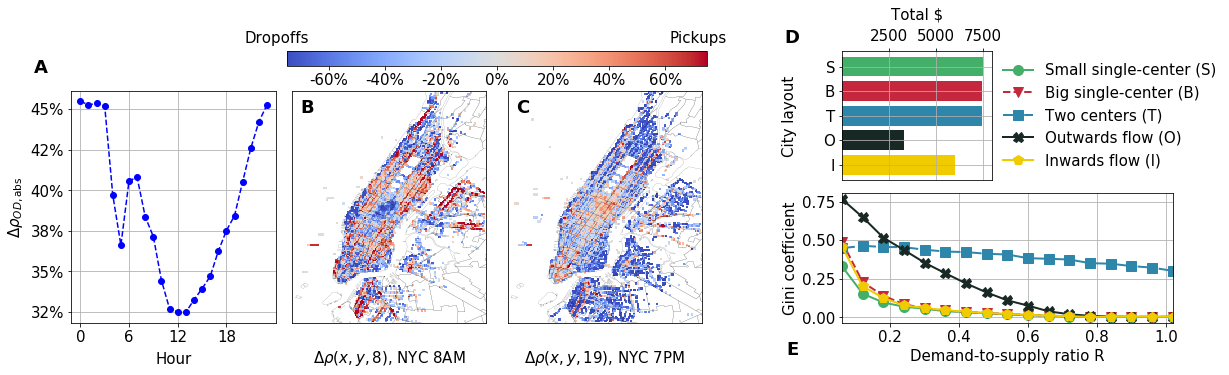

In [44]:
plt.rcParams['font.size'] = fs
plt.rcParams['figure.figsize'] = 17,5

gs1 = gridspec.GridSpec(2,3,height_ratios=(0.06,0.94))
gs1.update(left=0.05,right=0.57,wspace=0.05,hspace=0.2)
ax_cbar = plt.subplot(gs1[0,1:])
ax1 = plt.subplot(gs1[1,0])
ax2 = plt.subplot(gs1[1,1])
ax3 = plt.subplot(gs1[1,2])

gs2 = gridspec.GridSpec(2, 2)
gs2.update(left=0.68, right=0.95, hspace=0.1)
ax4 = plt.subplot(gs2[0,0])
ax5 = plt.subplot(gs2[1,:])

# calculating absolute value of differences
merged['sdiff_abs'] = merged['sdiff'].map(np.abs)
sdiff_abs = merged.groupby('hour').mean()['sdiff_abs']
ax1.plot(sdiff_abs.index,sdiff_abs.tolist(),'bo--')
#ax[0].errorbar(sdiff_abs.index,sdiff_abs.tolist(),yerr = merged.groupby('hour').std()['sdiff_abs'])
ax1.set_xlabel('Hour',labelpad=7)
ax1.set_ylabel(r'$\Delta \rho_{OD, \mathrm{abs}}$')
# setting percentage ticks
vals = ax1.get_yticks()
ax1.set_yticklabels(['{:.0%}'.format(x/100) for x in vals])
ax1.set_xticks([0,6,12,18])

cap=75
M = merged[merged.hour==8].pivot_table(index="lat",columns="lon",values="sdiff",fill_value=np.nan)
X,Y = np.meshgrid(M.columns,M.index)
Z = M.as_matrix()
ax2.pcolor(X,Y,Z,cmap='coolwarm',vmin=-cap,vmax=cap)
ax2.set_xlabel(r'$\Delta \rho(x,y,8)$, NYC 8AM')
tz.plot(ax=ax2,edgecolor='black',facecolor="none",linewidth=0.1)

# getting colorbar, plotting 7PM differences in OD matrix
M = merged[merged.hour==19].pivot_table(index="lat",columns="lon",values="sdiff",fill_value=np.nan)
X,Y = np.meshgrid(M.columns,M.index)
Z = M.as_matrix()
cax = ax3.pcolor(X,Y,Z,cmap='coolwarm',vmin=-cap,vmax=cap)
# adding plot title
ax3.set_xlabel(r'$\Delta \rho(x,y,19)$, NYC 7PM')
# plotting taxi zones
tz.plot(ax=ax3,edgecolor='black',facecolor="none",linewidth=0.1)
plt.colorbar(cax,cax=ax_cbar,format='%.0f%%',orientation='horizontal',shrink=0.8)

# removing map axes
for a in [ax2,ax3]:
    a.set_xlim(lonmin,lonmax)
    a.set_ylim(latmin,latmax)
    #ax[i].get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    a.tick_params(axis="x",colors="white")
    
cond_d_slice = (df['rho']==15)
cond_R_slice = df['R'].map(lambda r: int(round(100*r,0))%6==0)
cond_alg = (df['matching']=='nearest')
cond_geom = df['geom'].map(lambda g: int(g) in [0,1,2,3,6])
cond = cond_waiting&cond_d_slice&cond_alg&cond_geom&cond_R_slice

s = df[cond]\
.pivot_table(values='avg_trip_income_mean',index='R',columns='geom',aggfunc=lambda x: x).loc[0.48]
#colors.reverse()
ax4.barh(range(5),s.loc[[3,2,6,1,0]],color=colors[::-1][-5:])
ax4.set_yticks(range(5))
ax4.set_yticklabels(map(lambda k: geom_descr[k][0],[3,2,6,1,0]))
ax4.set_xlabel("Total $", labelpad=10)
ax4.set_xticks([2500,5000,7500])
ax4.set_xlim(0,8000)
ax4.xaxis.tick_top()
ax4.xaxis.set_label_position("top")
ax4.set_ylabel("City layout",labelpad=26)


#colors.reverse()
df[cond]\
.pivot_table(values='gini_mean',index='R',columns='geom',aggfunc=lambda x: x)\
.plot(ax=ax5,style=linestyles,color=colors,linewidth=2,markersize=10,legend=False)
for i, line in enumerate(ax5.get_lines()):
    line.set_marker(markers_all[i])

ax5.set_ylabel("Gini coefficient")
ax5.set_xlabel('Demand-to-supply ratio R')

# last two plots legend
handles, labels = ax5.get_legend_handles_labels()
ax4.legend(
    np.array(handles)[[0,1,2,3,4]], 
    map(lambda k: geom_descr[int(k)] + ' (' + geom_descr[int(k)][0] + ')',[0,1,6,2,3]), 
    loc='center left',bbox_to_anchor=(0.98,0.5),ncol=1,frameon=False)

axes = [ax1,ax2,ax3,ax4,ax5]
labels = ['A','B','C','D','E']
positions = [1,1,1,1,0]
offsets = [[-20,30],[25,-10],[25,-10],[-40,20],[-40,-20]]
fig=plt.gcf()

for ax, label, pos, offset in zip(axes, labels, positions, offsets):
    bbox = ax.bbox.corners()
    fig.text(bbox[pos][0]+offset[0], bbox[pos][1]+offset[1], label, fontsize=fs+3, fontweight="bold", va="center", ha="center",
             transform=None)

l1_pos = ax_cbar.bbox.corners()[1]
l2_pos = ax_cbar.bbox.corners()[3]
fig.text(l1_pos[0],l1_pos[1]+20,'Dropoffs',fontsize=fs,va="center",ha="center",transform=None)
fig.text(l2_pos[0],l2_pos[1]+20,'Pickups',fontsize=fs,va="center",ha="center",transform=None)

    
fig.savefig('fig2.pdf',dpi=600,bbox_inches='tight')

# Figure 3 - income distributions for different strategies 

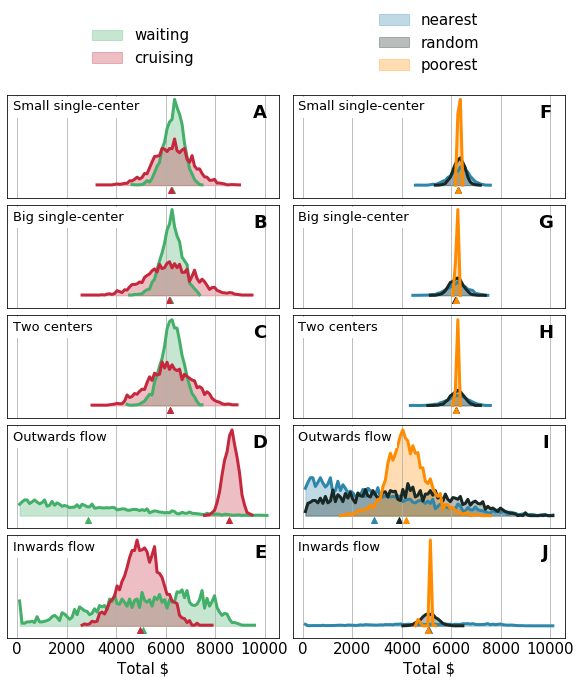

In [62]:
def get_incomes(parent_run_id):
    """
    Given a parent_run_id, this function returns the incomes of all taxis at the end of all the simulations.
    """
    
    e=[]
    for r in range(10):
        fname = '../results/run_' + parent_run_id + '_run_' +str(r)+ '_per_taxi_metrics.json.gz'
        try:
            e.append(gzip.open(fname,'rb').readlines()[-1])
        except FileNotFoundError:
            e.append('')
    ptm = []
    for x in e:
        if x!='':
            ptm += json.loads(re.sub('nan','null',x.decode('utf8').strip('\n')))['trip_income']
    return ptm

# selecting a specific part of the dataframe

cond1 = df['rho']==15
cond2 = df['R']==0.4
cond3 = df['matching'] == 'nearest'

cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])
cond5 = (df['behaviour']=='go_back') & (df['initial_conditions']=='base')# & pd.isnull(df['reset_time'])

# waiting
sdf1 = copy.deepcopy(df[cond1&cond2&cond3&cond4])
sdf1['behav'] = 'waiting'
# cruising
sdf2 = copy.deepcopy(df[cond1&cond2&cond3&cond5])
sdf2['behav'] = 'cruising'

sdf = pd.concat([sdf1,sdf2],ignore_index=False)

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','behav']]

sdf_flatten = sdf\
    .set_index(['geom','behav'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})

sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))

sdf['gini'] = sdf['incomes'].map(lambda l: gini(np.array(l)))

total_min1 = min(sdf['incomes'].map(lambda l: min(l)))
total_max1 = max(sdf['incomes'].map(lambda l: max(l)))

data1 = sdf.pivot_table(values='incomes',index='geom',columns='behav',aggfunc=lambda x:x)


plt.rcParams['figure.figsize']=10,10
fig, ax = plt.subplots(5,2,sharex=True)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data1['waiting'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)
    y2,x2 = np.histogram(data1['cruising'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)
    
    ax[i,0].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[0])
    ax[i,0].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[1])

    ymax = ax[i,0].get_ylim()[1]
    offset=0.05
    ax[i,0].scatter(np.mean(data1['waiting'][g]),-ymax*offset,marker='^',color=colors[0])
    ax[i,0].scatter(np.mean(data1['cruising'][g]), -ymax*offset,marker='^',color=colors[1])
    
    ax[i,0].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[0],alpha=0.3,label="waiting")
    ax[i,0].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[1],alpha=0.3,label="cruising")
    
    ax[i,0].grid(which='major',axis='y')
    ax[i,0].get_yaxis().set_visible(False)
    ax[i,0].tick_params(length=0)
    
    ax[i,0].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=13)    

ax[4,0].set_xlabel('Total $')
#fig.legend(*ax[0].get_legend_handles_labels(),loc=(0.2,0.92),frameon=False,ncol=2)
#fig.savefig('different_strategy.pdf',bbox_inches='tight')

# selecting a specific part of the dataframe

cond1 = (df['d']== 258)
cond2 = (df['R']==0.4)
cond4 = (df['behaviour']=='stay') & (df['initial_conditions']=='base')

# waiting
sdf = copy.deepcopy(df[cond1&cond2&cond4])

sdf.index = sdf.index.map(lambda s: re.sub('random','random_limited',s))

sdf['incomes'] = sdf.index.map(get_incomes)
sdf = sdf[['geom','incomes','matching']]
sdf_flatten = sdf\
    .set_index(['geom','matching'])['incomes']\
    .apply(pd.Series)\
    .stack()\
    .reset_index(level=0)\
    .reset_index()\
    .drop('level_1',axis=1)\
    .rename(columns={0:'income'})
    
sdf['mean_incomes'] = sdf['incomes'].map(lambda l: np.mean(l))
t = sdf.pivot_table(index='geom',values='mean_incomes',columns='matching')#.plot(style='o',ax=ax)

data2 = sdf.pivot_table(values='incomes',index='geom',columns='matching',aggfunc=lambda x:x)

for i,g in enumerate([0,1,6,2,3]):
    y1,x1 = np.histogram(data2['nearest'][g],bins=100,range=(0,10100),density=True)
    filt1=(y1!=0)|(np.roll(y1,1)!=0)|(np.roll(y1,-1)!=0)
    
    y2,x2 = np.histogram(data2['random'][g],bins=100,range=(0,10100),density=True)
    filt2=(y2!=0)|(np.roll(y2,1)!=0)|(np.roll(y2,-1)!=0)
    
    y3,x3 = np.histogram(data2['poorest'][g],bins=100,range=(0,10100),density=True)
    filt3=(y3!=0)|(np.roll(y3,1)!=0)|(np.roll(y3,-1)!=0)
    
    
    ax[i,1].plot(x1[1:][filt1],y1[filt1],'-',lw=3,color=colors[2])
    ax[i,1].plot(x1[1:][filt2],y2[filt2],'-',lw=3,color=colors[3])
    ax[i,1].plot(x1[1:][filt3],y3[filt3],'-',lw=3,color=colors[6])
    

    ymax = ax[i,1].get_ylim()[1]
    offset=0.05
    ax[i,1].scatter(np.mean(data2['nearest'][g]),-ymax*offset,marker='^',color=colors[2])
    ax[i,1].scatter(np.mean(data2['random'][g]), -ymax*offset,marker='^',color=colors[3])
    ax[i,1].scatter(np.mean(data2['poorest'][g]),-ymax*offset,marker='^',color=colors[6])
    
    ax[i,1].fill_between(x1[1:][filt1],y1[filt1],y2=0,color=colors[2],alpha=0.3,label="nearest")
    ax[i,1].fill_between(x1[1:][filt2],y2[filt2],y2=0,color=colors[3],alpha=0.3,label="random")
    ax[i,1].fill_between(x1[1:][filt3],y3[filt3],y2=0,color=colors[6],alpha=0.3,label="poorest")
    
    ax[i,1].grid(which='major',axis='y')
    ax[i,1].get_yaxis().set_visible(False)
    ax[i,1].tick_params(length=0)

    ax[i,1].annotate(s=geom_descr[g],xy=(0.02,0.85),xycoords='axes fraction',backgroundcolor='white',fontsize=13)
    
ax[4,1].set_xlabel('Total $')
h1,l1 = ax[0,0].get_legend_handles_labels()
h2,l2 = ax[0,1].get_legend_handles_labels()
ax[0,0].legend(h1,l1,loc='lower center',bbox_to_anchor=(0.5,1.15),frameon=False,ncol=1)
ax[0,1].legend(h2,l2,loc='lower center',bbox_to_anchor=(0.5,1.08),frameon=False,ncol=1)

fig.subplots_adjust(hspace=0.07,wspace=0.05)

axes = np.reshape(ax,10,order='F')
labels = ['A','B','C','D','E','F','G','H','I','J']
positions = [0]*10
offsets = [[170,40]]*10

for ax, label, pos, offset in zip(axes, labels, positions, offsets):
    bbox = ax.bbox.corners()
    fig.text(bbox[pos][0]+offset[0], bbox[pos][1]+offset[1], label, fontsize=fs+3, fontweight="bold", va="center", ha="center",
             transform=None)
    
fig.savefig('fig3.pdf',dpi=600,bbox_inches='tight')